# Libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

# Functions

In [2]:
def detect_iqr_outliers(df, column, multiplier=1.5):
    """
    Detects outliers in a numeric column using the IQR method.
    Returns a boolean Series where True = outlier.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Import data

In [3]:
df = pd.read_parquet("../data/raw/eod_data.parquet")
df.head()

,date,symbol,open,high,low,close,volume,adj_close
0,2024-11-04 00:00:00+00:00,AAPL,220.990,222.79,219.7100,222.01,44903300.0,222.01
1,2024-11-04 00:00:00+00:00,AMZN,196.450,197.33,194.3101,195.78,38479697.0,195.78
2,2024-11-04 00:00:00+00:00,GOOGL,169.930,170.73,168.0110,169.24,21492744.0,169.24
3,2024-11-04 00:00:00+00:00,META,564.100,568.69,557.8900,560.68,12064600.0,560.68
4,2024-11-04 00:00:00+00:00,MSFT,409.855,410.41,405.5750,408.46,19284886.0,408.46


# EDA

## First look

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       1000 non-null   datetime64[ns, UTC]
 1   symbol     1000 non-null   object             
 2   open       1000 non-null   float64            
 3   high       1000 non-null   float64            
 4   low        1000 non-null   float64            
 5   close      1000 non-null   float64            
 6   volume     1000 non-null   float64            
 7   adj_close  1000 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(1)
memory usage: 62.6+ KB


> All columns are having the correct types.

In [5]:
df.symbol.nunique() # ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'TSLA']

7

> Correct 7 tickers

In [6]:
df.date = df.date.dt.date # Remove time stamp since it's EOD data
df.head()

,date,symbol,open,high,low,close,volume,adj_close
0,2024-11-04,AAPL,220.990,222.79,219.7100,222.01,44903300.0,222.01
1,2024-11-04,AMZN,196.450,197.33,194.3101,195.78,38479697.0,195.78
2,2024-11-04,GOOGL,169.930,170.73,168.0110,169.24,21492744.0,169.24
3,2024-11-04,META,564.100,568.69,557.8900,560.68,12064600.0,560.68
4,2024-11-04,MSFT,409.855,410.41,405.5750,408.46,19284886.0,408.46


In [7]:
df.close.equals(df.adj_close)

False

> Close and Adjusted close have the same values, can omit 1 column

In [8]:
df = df.drop(columns=["adj_close"], axis=1)

## Null / Duplicate

In [9]:
df.isnull().sum()

date      0
symbol    0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

> There's no nulls or duplicates

## Numerical distribution

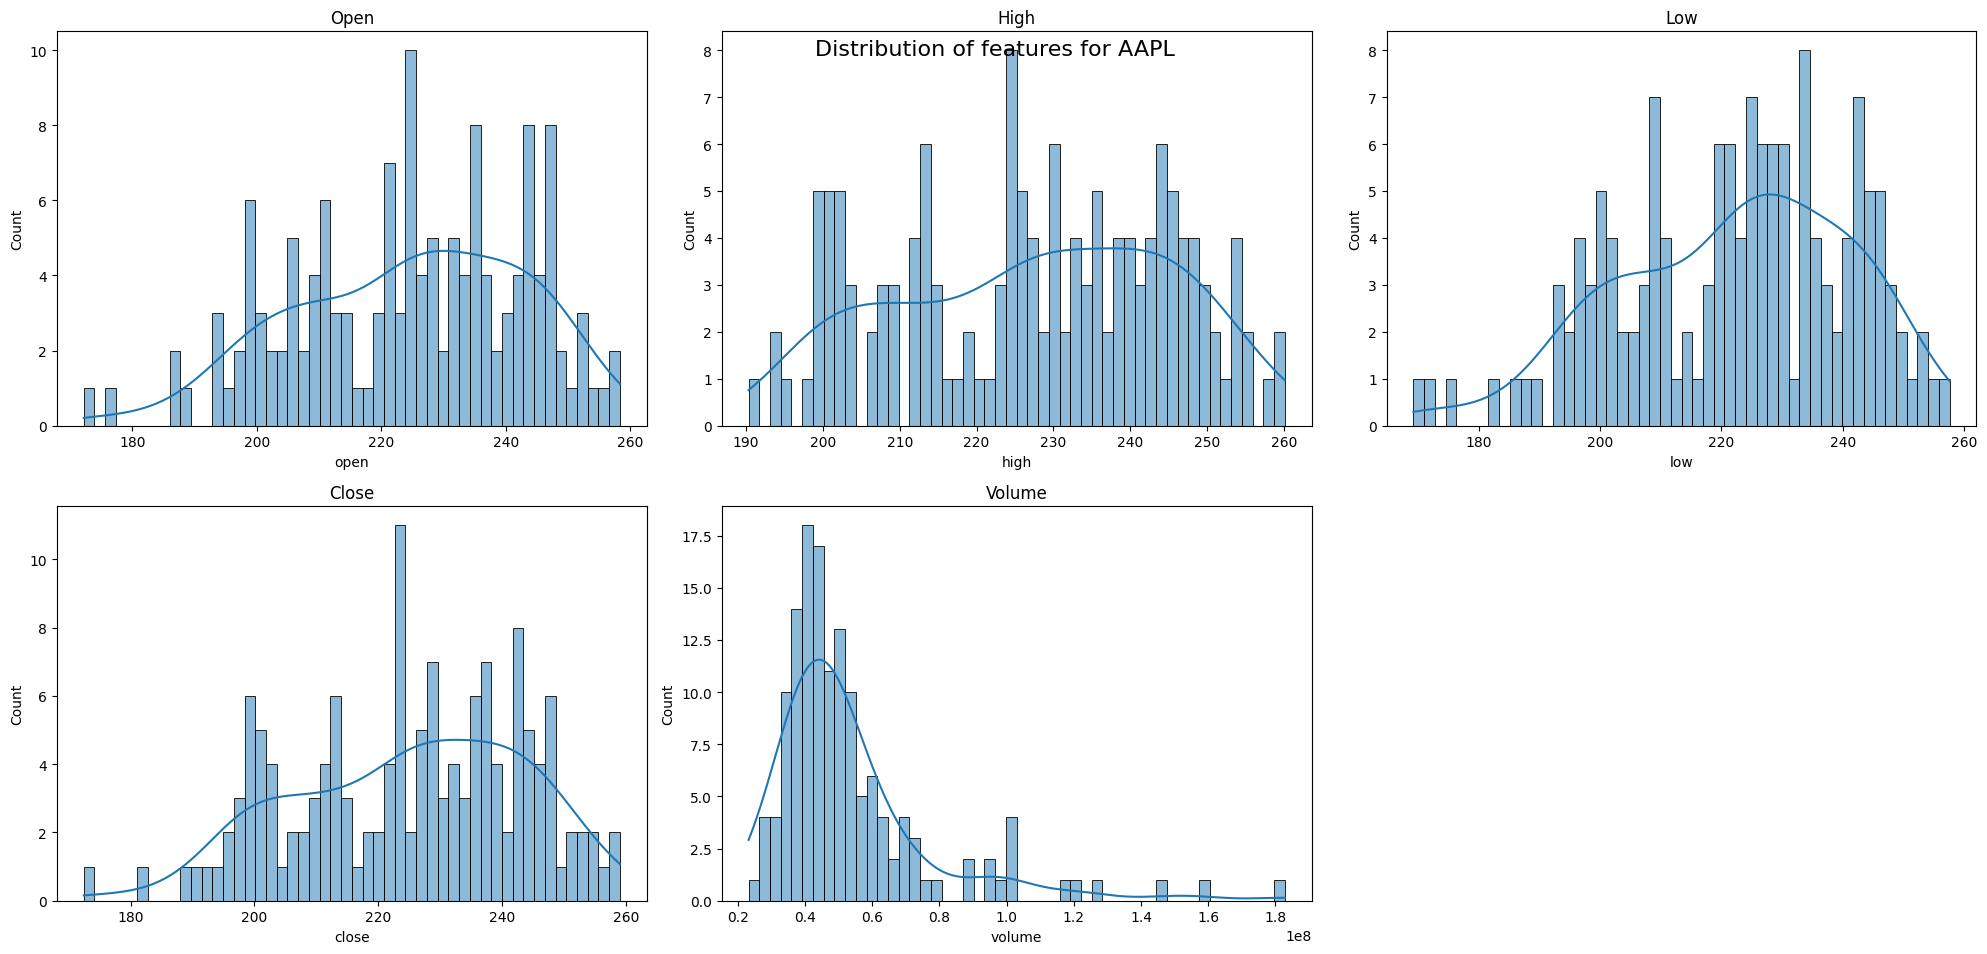

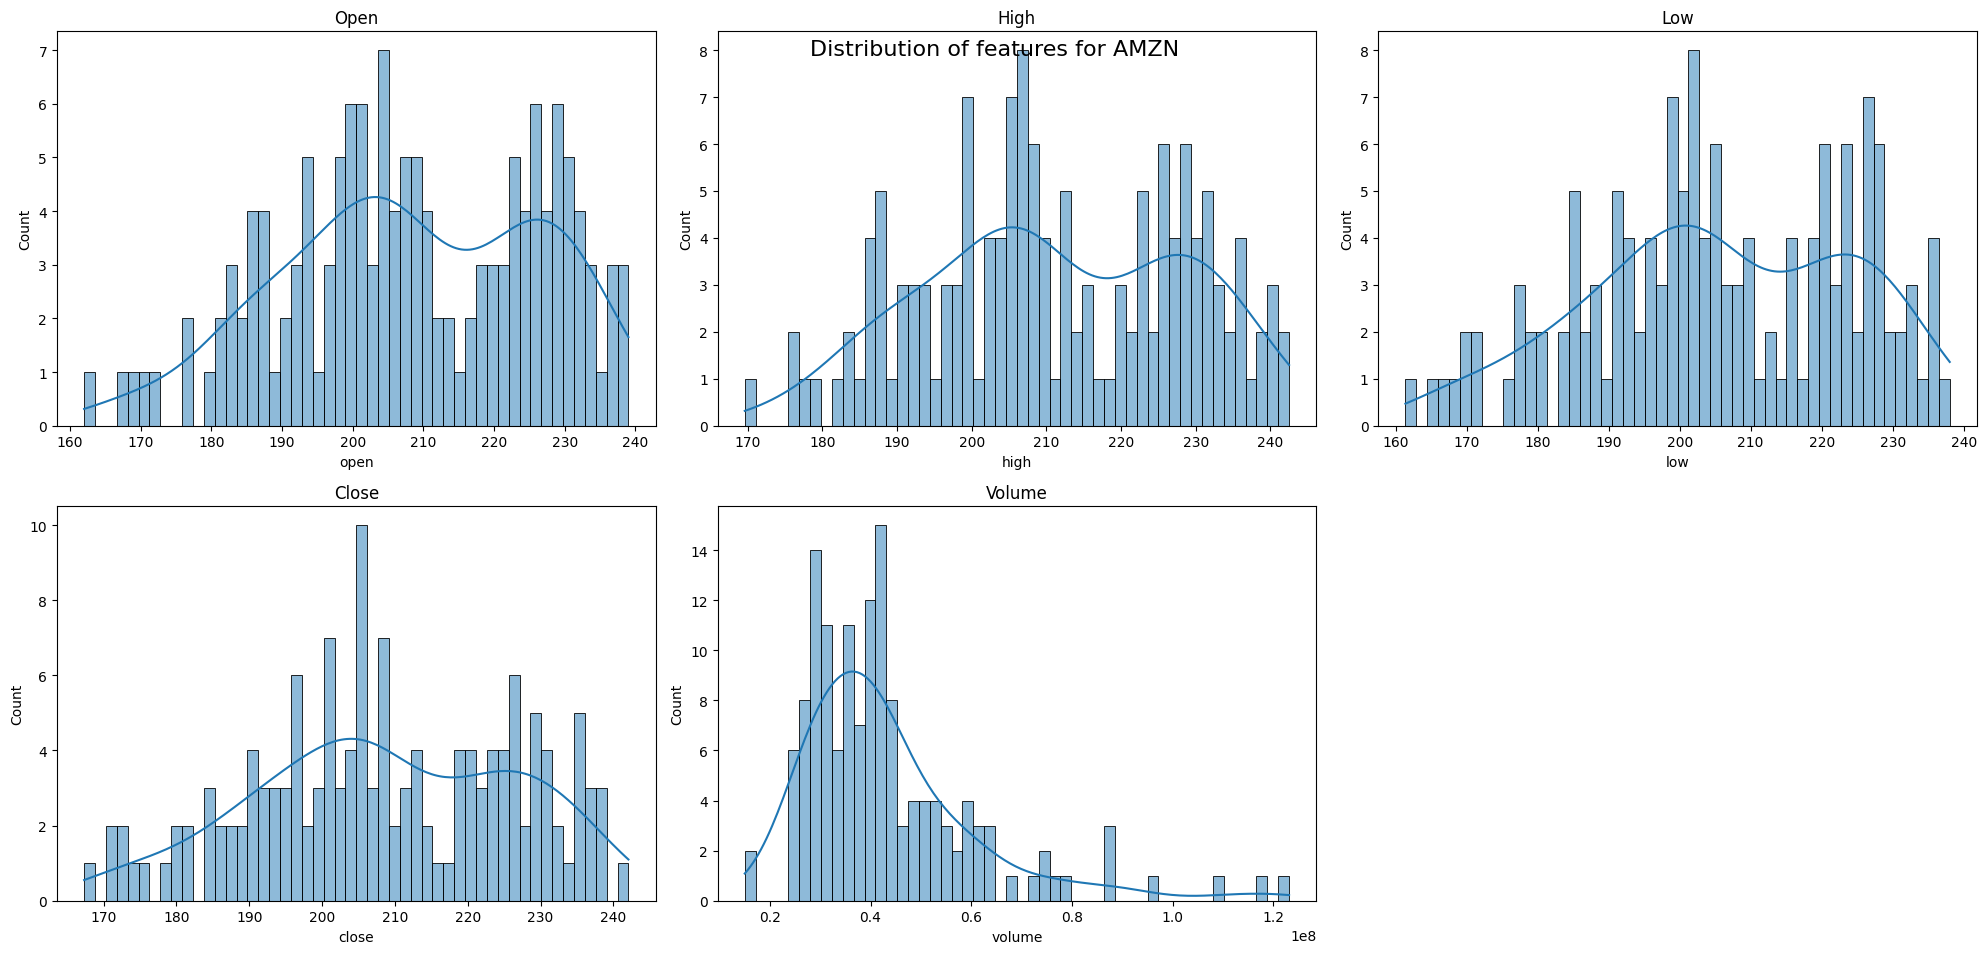

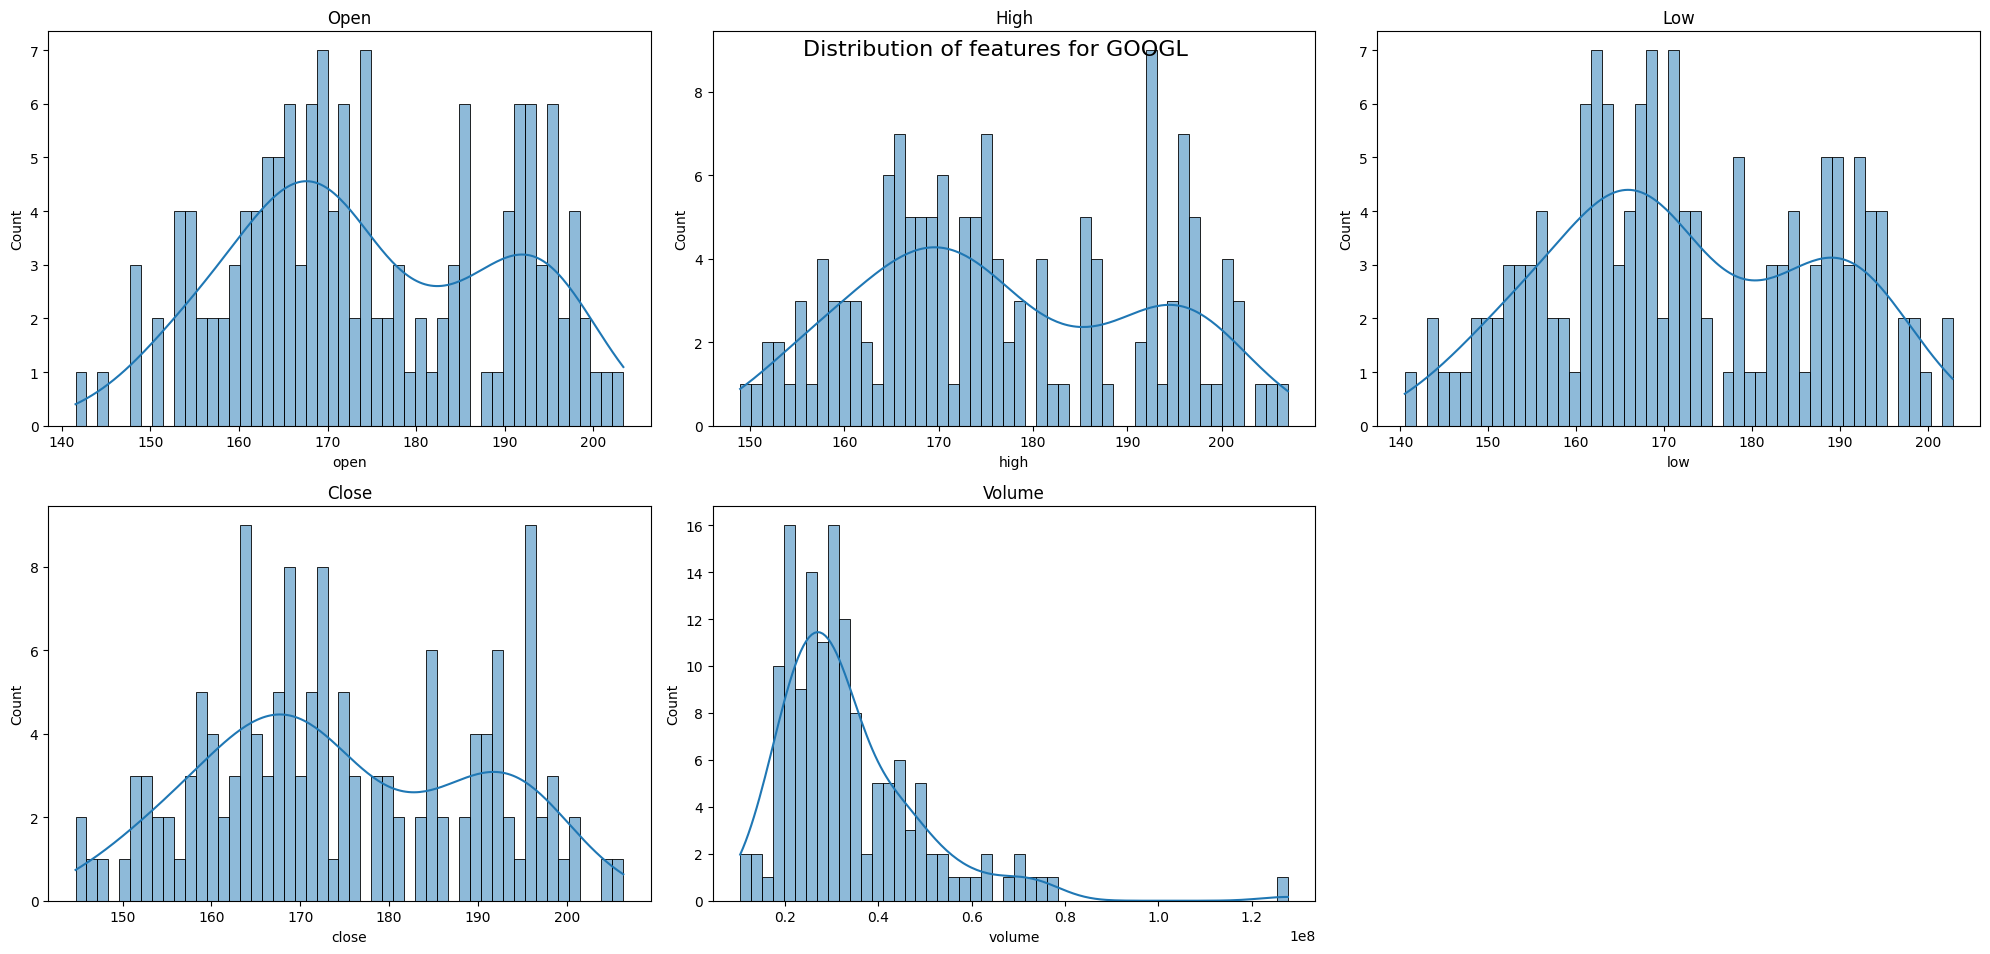

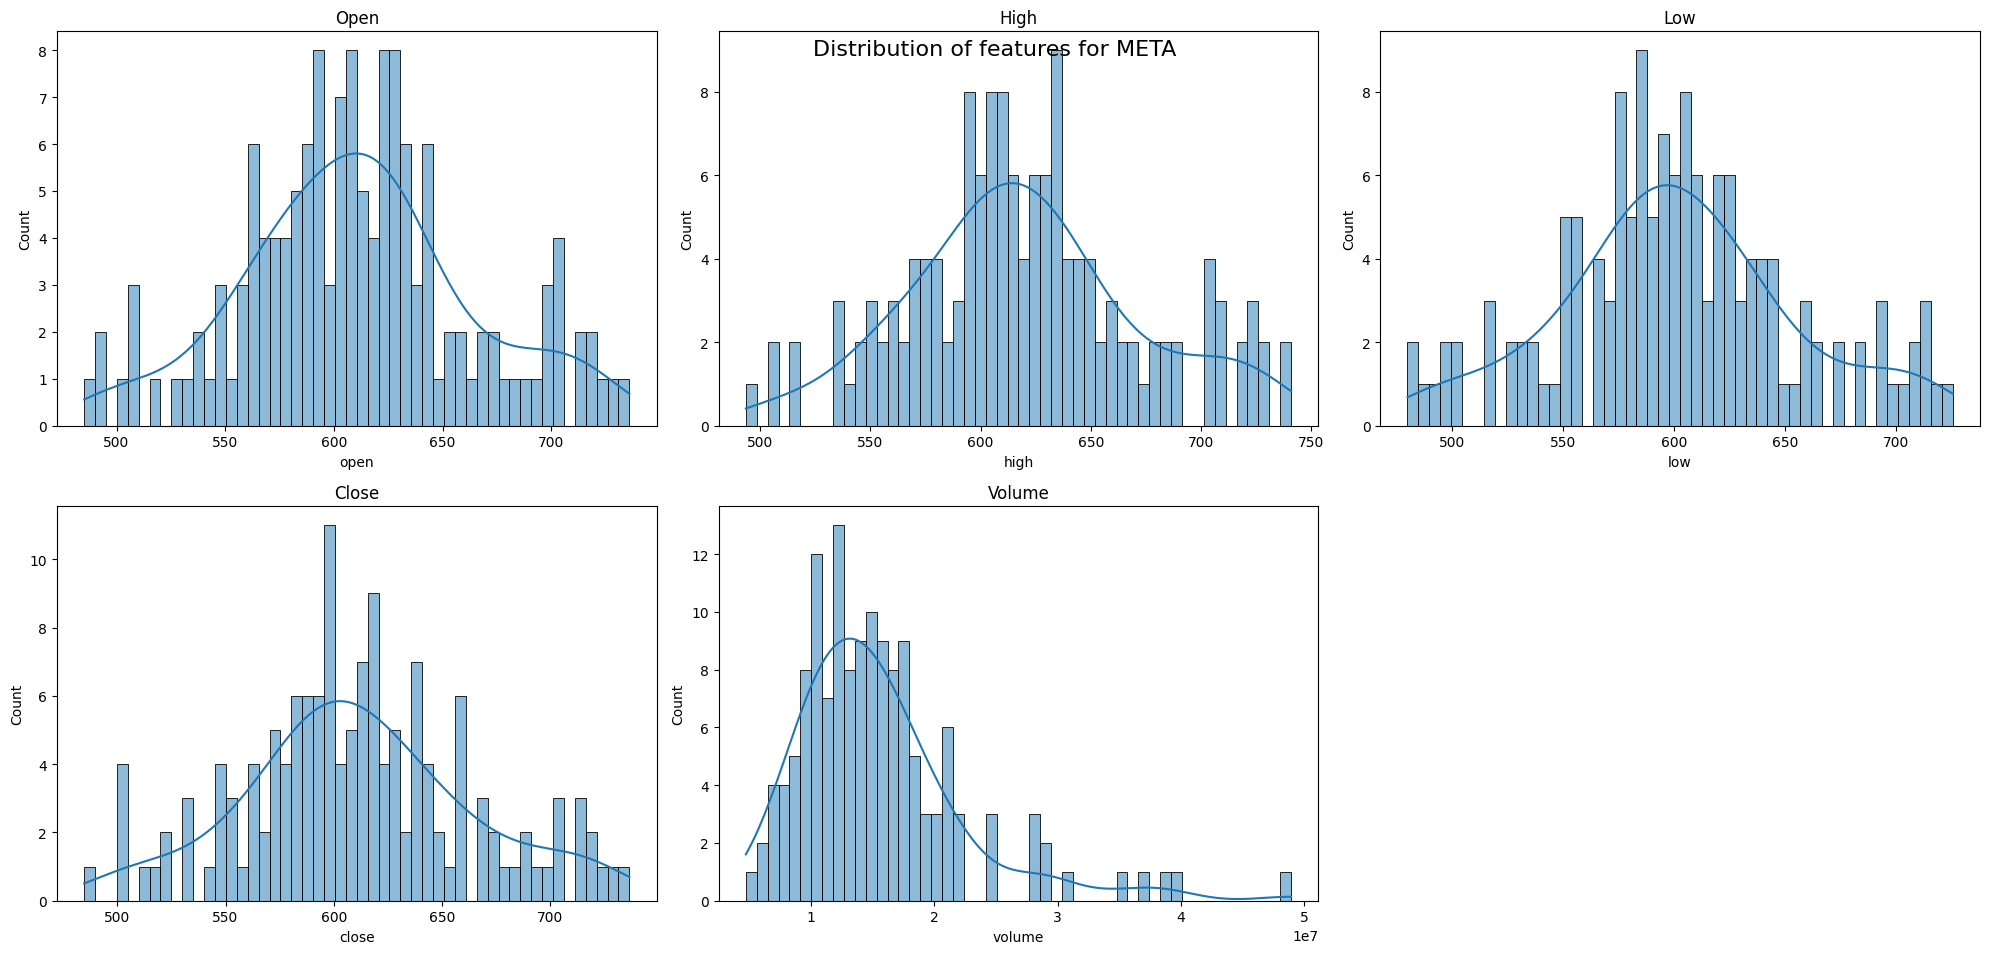

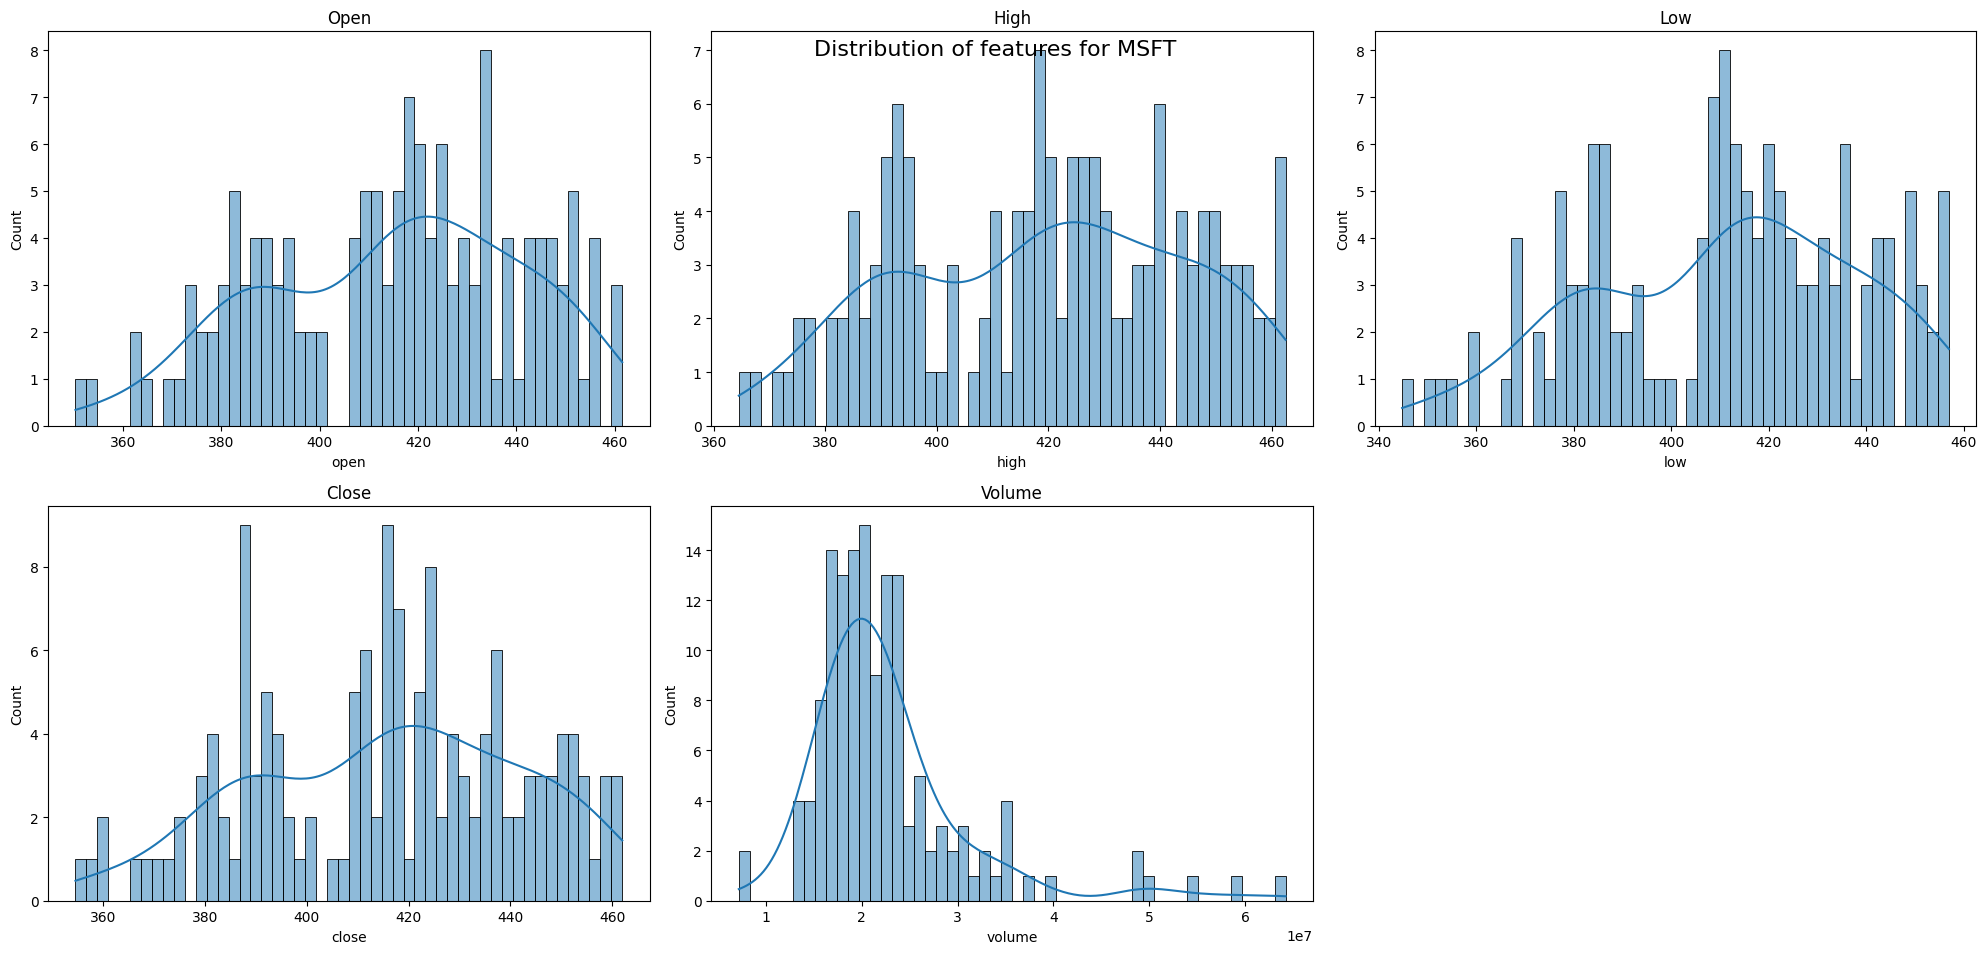

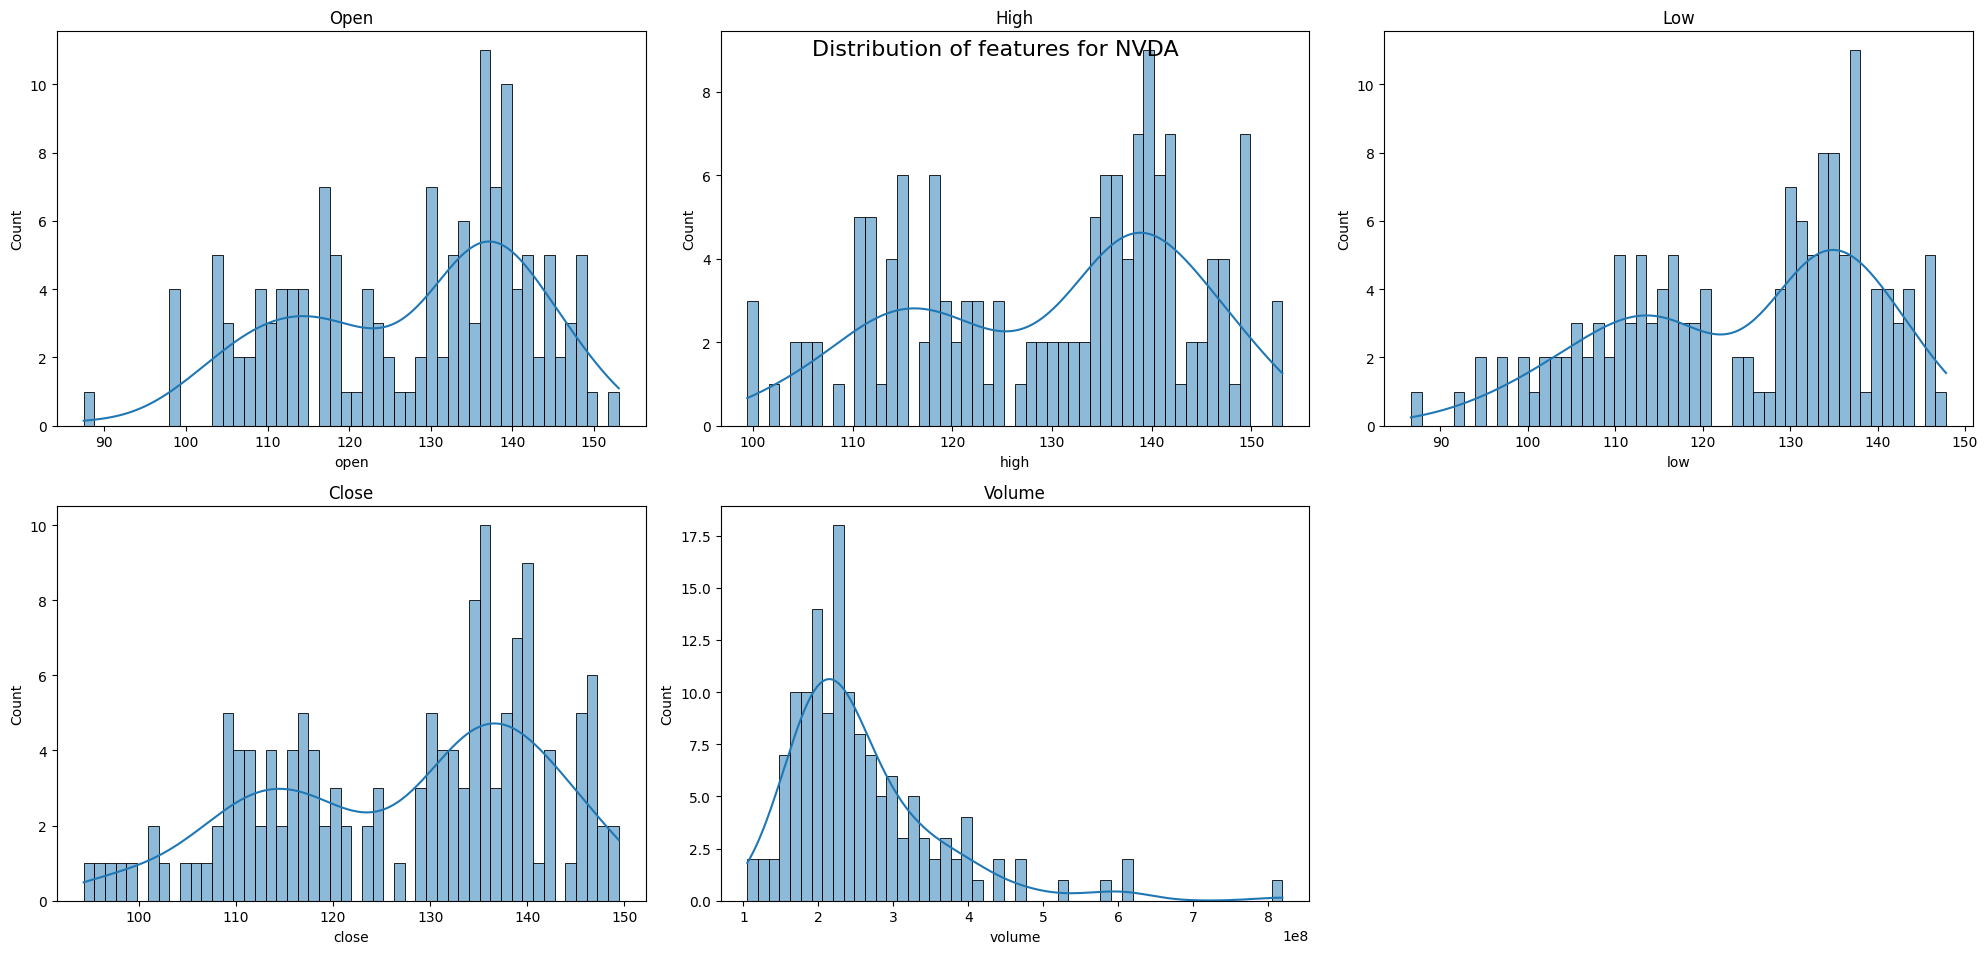

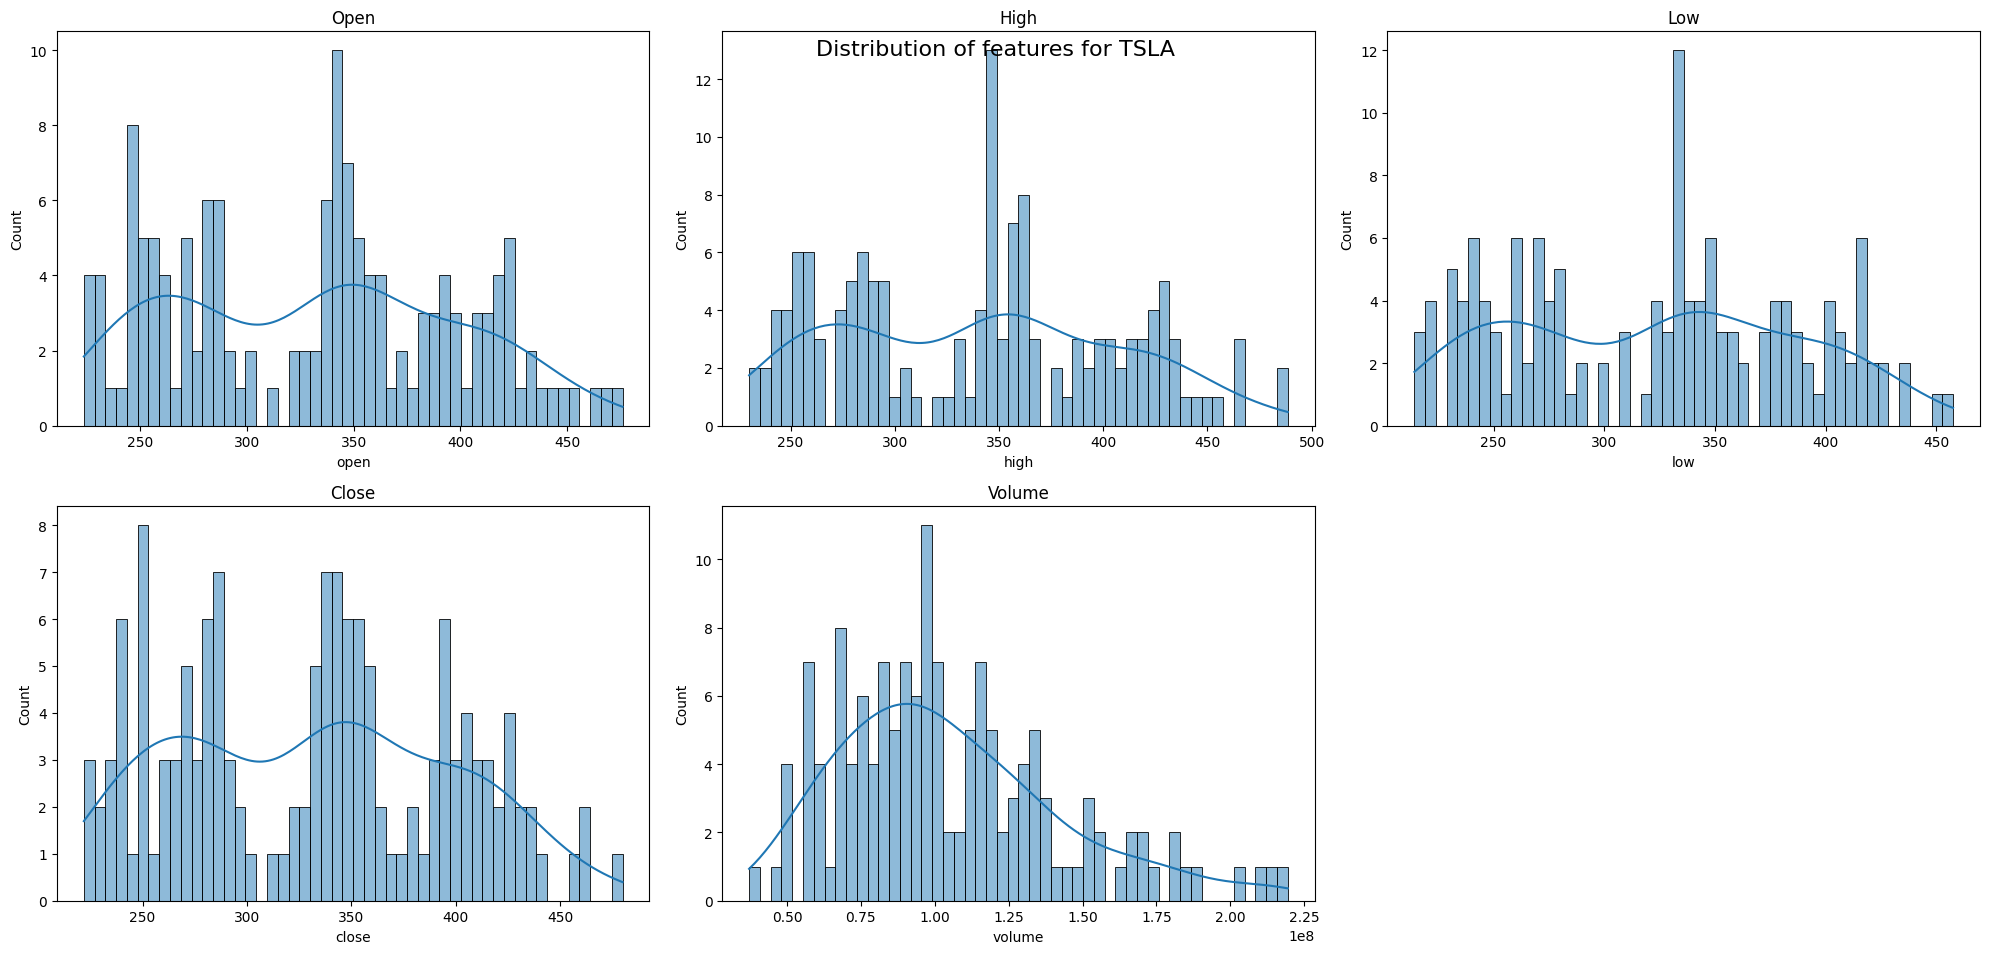

In [11]:
features = ["open", "high", "low", "close", "volume"]
tickers = df["symbol"].unique()

for ticker in tickers:
    subset = df[df["symbol"] == ticker]
    plt.figure(figsize=(20, 10))
    plt.suptitle(f"Distribution of features for {ticker}", fontsize=16, y=0.92)

    for i, col in enumerate(features):
        plt.subplot(2, 3, i + 1)
        sns.histplot(subset[col], kde=True, bins=50)
        plt.title(col.capitalize())
    plt.tight_layout()
    plt.show()

>
**Price distribution (Open, High, Low, Close)**

* Except for Meta, which has a near normal distribution bell curve, the rest don't have a near perfect normal bell curve but a multi-modal pattern.

**Volume distribution**

* Heavily right-skewed across all tickers. --> Possible further investigation to detect any outlier.

## Outliers

In [12]:
features = ["open", "high", "low", "close", "volume"]

for col in features:
    df[f"{col}_outlier"] = df.groupby("symbol", group_keys=False).apply(
        lambda g: detect_iqr_outliers(g, col)
    )

outliers = df[
    (df["open_outlier"]) |
    (df["high_outlier"]) |
    (df["low_outlier"]) |
    (df["close_outlier"]) |
    (df["volume_outlier"])
]

print(f"Total outliers detected: {len(outliers)}")
outliers.head()


Total outliers detected: 73


,date,symbol,open,high,low,close,volume,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier
34,2024-11-08,TSLA,299.14,328.71,297.66,321.22,204782763.0,False,False,False,False,True
41,2024-11-11,TSLA,346.30,358.64,336.00,350.00,210521625.0,False,False,False,False,True
64,2024-11-15,AMZN,206.76,207.34,199.61,202.61,86591144.0,False,False,False,False,True
105,2024-11-25,AAPL,231.46,233.25,229.74,232.87,89984500.0,False,False,False,False,True
184,2024-12-11,GOOGL,185.31,195.61,184.85,195.40,67894071.0,False,False,False,False,True


>
Upon research, **outliers in stock market data are often normal** and represent real market events (e.g., earnings announcements, stock splits, or sudden macroeconomic changes).

**Plan:**  Evaluate both versions of the dataset — with and without scaling — to assess model performance sensitivity to outlier handling.


## Relationship

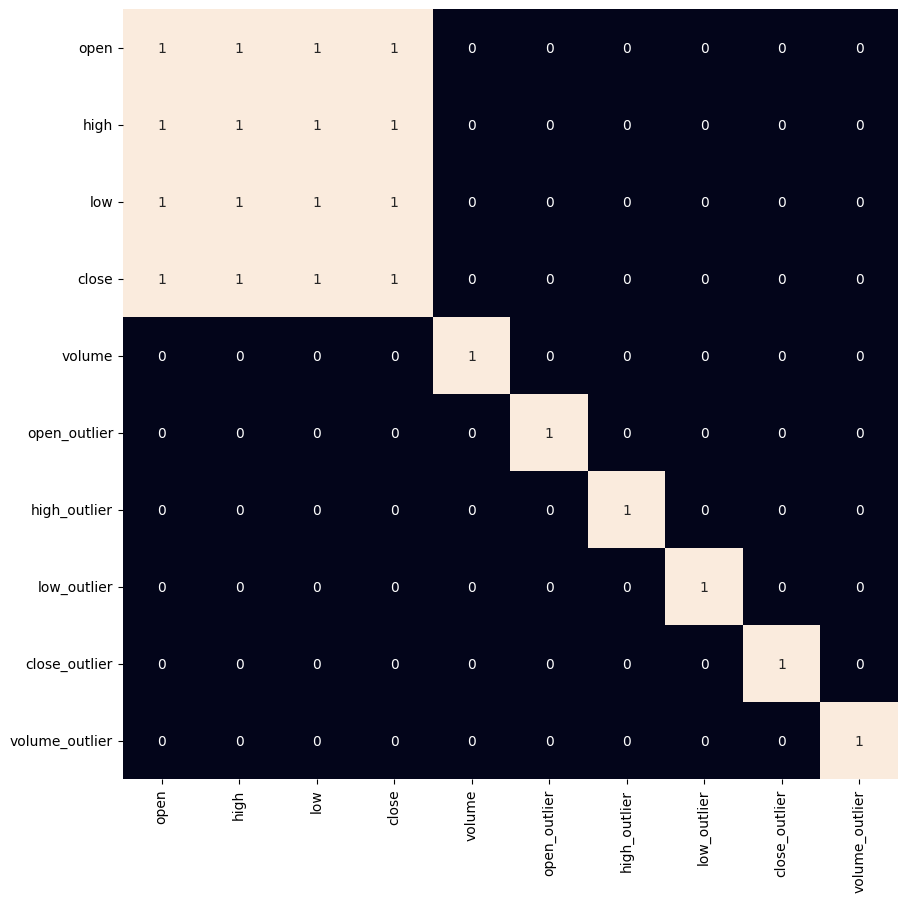

In [13]:
plt.figure(figsize=(10, 10)) 

sns.heatmap(df.drop(['date', 'symbol'], axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

> 
* The **price-related features (`open`, `high`, `low`, `close`) are perfectly correlated** (r ≈ 1). → This indicates high redundancy — they move together as part of the same daily price structure.
* outlier columns are exempted since they serve different purposes.

--> One price column (e.g., `close`) may be sufficient to represent price level.


## Time-series analysis

In [14]:
# Ensure date is a pandas datetime (not python date/object)
df["date"] = pd.to_datetime(df["date"], errors="raise")

# Create separate integer columns
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

df.head()

,date,symbol,open,high,low,close,volume,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier,day,month,year
0,2024-11-04,AAPL,220.990,222.79,219.7100,222.01,44903300.0,False,False,False,False,False,4,11,2024
1,2024-11-04,AMZN,196.450,197.33,194.3101,195.78,38479697.0,False,False,False,False,False,4,11,2024
2,2024-11-04,GOOGL,169.930,170.73,168.0110,169.24,21492744.0,False,False,False,False,False,4,11,2024
3,2024-11-04,META,564.100,568.69,557.8900,560.68,12064600.0,False,False,False,False,False,4,11,2024
4,2024-11-04,MSFT,409.855,410.41,405.5750,408.46,19284886.0,False,False,False,False,False,4,11,2024


In [15]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,date,symbol,open,high,low,close,volume,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier,day,month,year,is_quarter_end
0,2024-11-04,AAPL,220.990,222.79,219.7100,222.01,44903300.0,False,False,False,False,False,4,11,2024,0
1,2024-11-04,AMZN,196.450,197.33,194.3101,195.78,38479697.0,False,False,False,False,False,4,11,2024,0
2,2024-11-04,GOOGL,169.930,170.73,168.0110,169.24,21492744.0,False,False,False,False,False,4,11,2024,0
3,2024-11-04,META,564.100,568.69,557.8900,560.68,12064600.0,False,False,False,False,False,4,11,2024,0
4,2024-11-04,MSFT,409.855,410.41,405.5750,408.46,19284886.0,False,False,False,False,False,4,11,2024,0


In [16]:
df.groupby("is_quarter_end").mean(numeric_only=True)

,open,high,low,close,volume,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier,day,month,year
is_quarter_end,,,,,,,,,,,,,
0,297.732936,302.492028,293.153797,298.161657,7.754634e+07,0.004286,0.004286,0.007143,0.002857,0.082857,15.870000,4.56,2024.81
1,302.069563,306.554002,297.070826,301.920767,7.273709e+07,0.000000,0.000000,0.000000,0.000000,0.033333,15.603333,7.47,2024.51


> Trade price is indeed higher during quarter end. Trade volume decrease.

## Target

In [17]:
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

df["target"] = (df.groupby("symbol")["close"].shift(-1) > df["close"]).astype(int)

In [18]:
# Sanity check
for sym in df["symbol"].unique():
    check = df.loc[df["symbol"] == sym, ["date","close","target"]].head(5)
    print(f"\n{sym}")
    print(check)


AAPL
        date   close  target
0 2024-11-04  222.01       1
1 2024-11-05  223.45       0
2 2024-11-06  222.72       1
3 2024-11-07  227.48       0
4 2024-11-08  226.96       0

AMZN
          date   close  target
143 2024-11-04  195.78       1
144 2024-11-05  199.50       1
145 2024-11-06  207.09       1
146 2024-11-07  210.05       0
147 2024-11-08  208.18       0

GOOGL
          date   close  target
286 2024-11-04  169.24       1
287 2024-11-05  169.74       1
288 2024-11-06  176.51       1
289 2024-11-07  180.75       0
290 2024-11-08  178.35       1

META
          date   close  target
429 2024-11-04  560.68       1
430 2024-11-05  572.43       0
431 2024-11-06  572.05       1
432 2024-11-07  591.70       0
433 2024-11-08  589.34       0

MSFT
          date   close  target
572 2024-11-04  408.46       1
573 2024-11-05  411.46       1
574 2024-11-06  420.18       1
575 2024-11-07  425.43       0
576 2024-11-08  422.54       0

NVDA
          date   close  target
715 2024-11-04

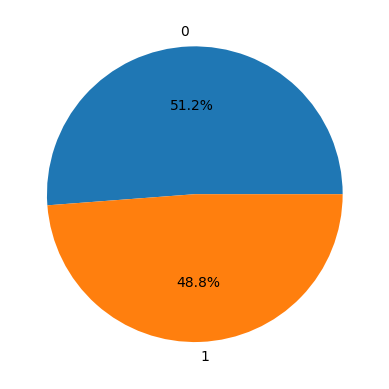

In [19]:
plt.pie(df['target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

> Roughly 50-50 ratio for the target, no imbalance problem in this case.

# Reference

* [Stock Price Prediction using Machine Learning in Python](https://www.geeksforgeeks.org/machine-learning/stock-price-prediction-using-machine-learning-in-python/)